In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3PL item response function
def p_3pl(theta, a, b, c):
    """
    theta: 1D array (n_persons,)
    a, b, c: scalars
    returns: 1D array of P(X=1 | theta)
    """
    z = a * (theta - b)
    L = 1.0 / (1.0 + np.exp(-z))   # logistic
    return c + (1 - c) * L

def loglik_3pl(response_df, abilities_df, items_df, id_col="participant_id"):
    """
    Approximate log-likelihood of observed responses given:
    - response_df: wide format, id_col + item columns (0/1)
    - abilities_df: columns [id_col, theta]
    - items_df: columns [item_id, a, b, c]
    Assumes item_id names match column names in response_df.
    Uses plug-in person thetas (no integration).
    """
    # Align persons
    df = response_df.merge(abilities_df, on=id_col, how="inner")
    thetas = df["theta"].values

    item_cols = [col for col in df.columns if col not in [id_col, "theta"]]

    # Make sure items_df is indexed by item_id for easy lookup
    items = items_df.set_index("item_id").loc[item_cols]

    loglik_total = 0.0
    n_persons = df.shape[0]

    for item in item_cols:
        a = items.loc[item, "a"]
        b = items.loc[item, "b"]
        c = items.loc[item, "c"]

        x = df[item].values  # 0/1
        p = p_3pl(thetas, a, b, c)

        # avoid log(0)
        eps = 1e-12
        p = np.clip(p, eps, 1 - eps)

        loglik_item = x * np.log(p) + (1 - x) * np.log(1 - p)
        loglik_total += loglik_item.sum()

    return loglik_total


In [2]:
# ---- Update these paths if needed ----
base_resp_path   = "IRTMatrix.csv"
base_items_path  = "IRTMatrix_items.csv"
base_abil_path   = "IRTMatrix_abilities.csv"

ext_resp_path    = "IRTMatrixExtended.csv"
ext_items_path   = "IRTMatrixExtended_items.csv"
ext_abil_path    = "IRTMatrixExtended_abilities.csv"
# --------------------------------------

base_resp  = pd.read_csv(base_resp_path)
base_items = pd.read_csv(base_items_path)
base_abil  = pd.read_csv(base_abil_path)

ext_resp   = pd.read_csv(ext_resp_path)
ext_items  = pd.read_csv(ext_items_path)
ext_abil   = pd.read_csv(ext_abil_path)


In [3]:
# Log-likelihoods
ll_base = loglik_3pl(base_resp, base_abil, base_items)
ll_ext  = loglik_3pl(ext_resp,  ext_abil,  ext_items)

# Number of items
J_base = base_items.shape[0]
J_ext  = ext_items.shape[0]

# Number of item parameters (3PL)
k_base = 3 * J_base
k_ext  = 3 * J_ext

# Number of persons (assume same in both)
N = base_resp.shape[0]

# AIC and BIC (using item-parameter counts)
def aic_bic(loglik, k, N):
    aic = -2 * loglik + 2 * k
    bic = -2 * loglik + k * np.log(N)
    return aic, bic

aic_base, bic_base = aic_bic(ll_base, k_base, N)
aic_ext,  bic_ext  = aic_bic(ll_ext,  k_ext,  N)

print("Model A (1 item / level):")
print(f"  logLik = {ll_base:.1f}")
print(f"  AIC    = {aic_base:.1f}")
print(f"  BIC    = {bic_base:.1f}")

print("\nModel B (3 items / level):")
print(f"  logLik = {ll_ext:.1f}")
print(f"  AIC    = {aic_ext:.1f}")
print(f"  BIC    = {bic_ext:.1f}")


Model A (1 item / level):
  logLik = -1580.0
  AIC    = 3285.9
  BIC    = 3572.8

Model B (3 items / level):
  logLik = -6523.8
  AIC    = 13425.5
  BIC    = 14286.2


          theta_A     theta_B
count  702.000000  702.000000
mean     0.137815    0.306523
std      1.026476    1.247447
min     -3.268264   -4.349264
25%     -0.377198   -0.565694
50%      0.016874    0.301452
75%      0.778390    1.227603
max      2.237984    2.874879

Correlation between theta (A vs B): 0.977


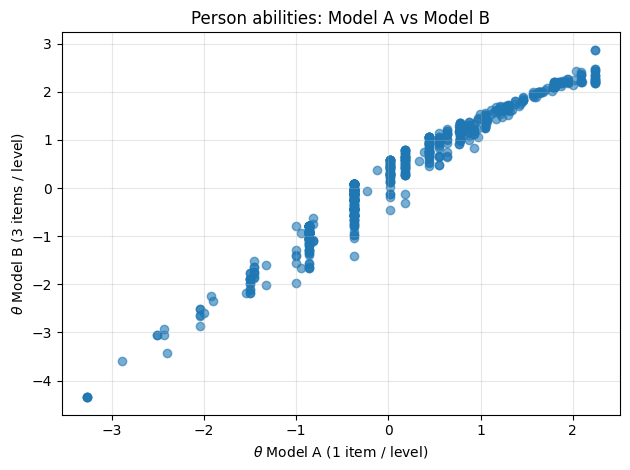

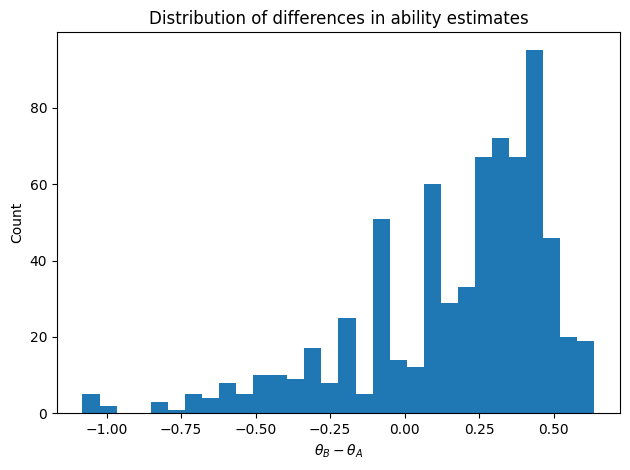

In [5]:
# Merge abilities from both models on participant_id
ab_merged = base_abil.merge(
    ext_abil,
    on="participant_id",
    suffixes=("_A", "_B")
)

print(ab_merged[["theta_A", "theta_B"]].describe())

# Correlation
corr = ab_merged["theta_A"].corr(ab_merged["theta_B"])
print(f"\nCorrelation between theta (A vs B): {corr:.3f}")

# Scatterplot
plt.figure()
plt.scatter(ab_merged["theta_A"], ab_merged["theta_B"], alpha=0.6)
plt.xlabel(r"$\theta$ Model A (1 item / level)")
plt.ylabel(r"$\theta$ Model B (3 items / level)")
plt.title("Person abilities: Model A vs Model B")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Differences
ab_merged["diff"] = ab_merged["theta_B"] - ab_merged["theta_A"]

plt.figure()
plt.hist(ab_merged["diff"], bins=30)
plt.xlabel(r"$\theta_B - \theta_A$")
plt.ylabel("Count")
plt.title("Distribution of differences in ability estimates")
plt.tight_layout()
plt.show()



[Section A] Score/Percentage diagnostics


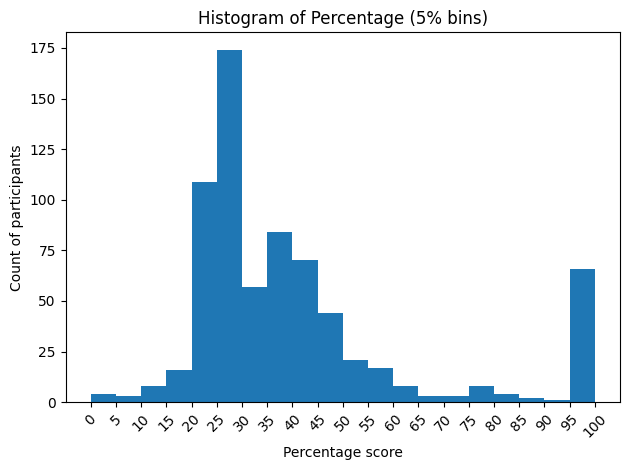

Difference (Percentage - Score/21*100) summary:
count    7.020000e+02
mean     1.619471e-16
std      1.509445e-15
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.421085e-14
dtype: float64


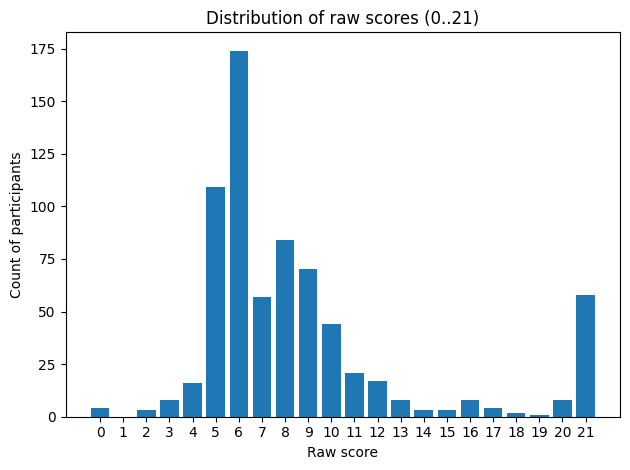

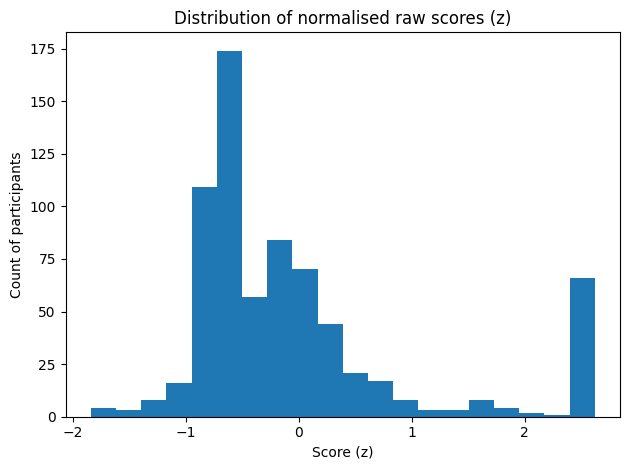


[Section B] Model A: theta distribution


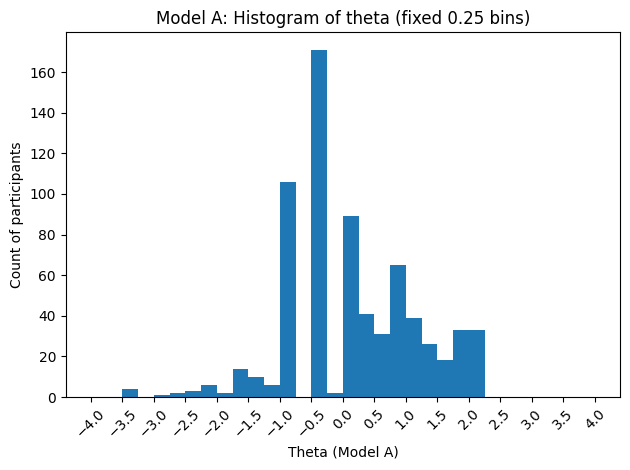

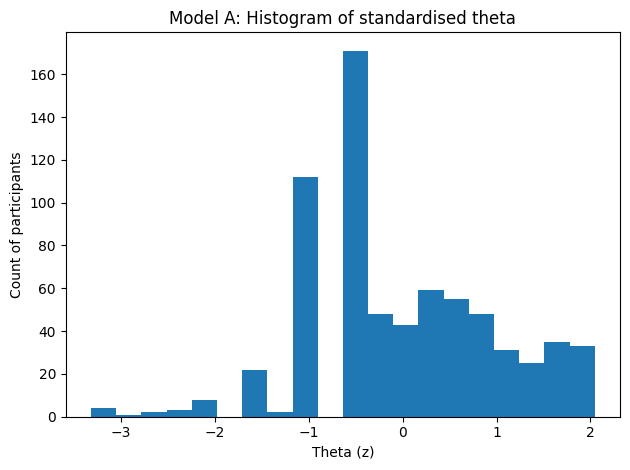

count    702.000000
mean       0.137815
std        1.026476
min       -3.268264
25%       -0.377198
50%        0.016874
75%        0.778390
max        2.237984
Name: theta, dtype: float64

[Section C] Score ↔ theta relationship (Model A)


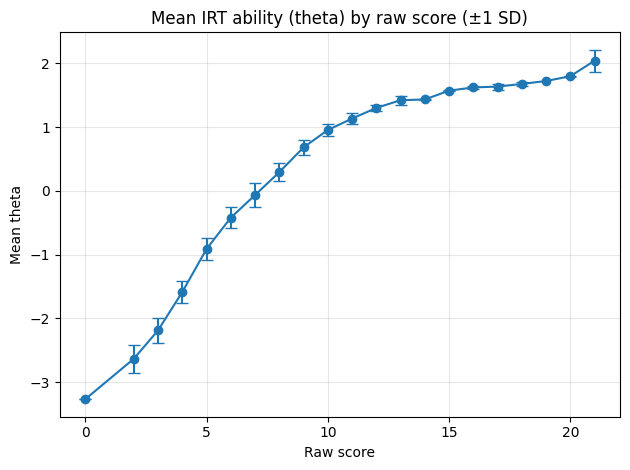

Linear fit (individuals): theta ≈ 0.197*Score + -1.569


ModuleNotFoundError: No module named 'scipy'

In [7]:
"""
Psychometrics scoring vs IRT analysis (end-to-end)
--------------------------------------------------
This script reproduces all analyses and plots we've discussed:

A) Pre-IRT score/percentage diagnostics
   - Histogram of Percentage in 5% bins
   - Check Percentage == Score/21*100
   - Raw score distribution (0..21)
   - Normalised raw scores (z)
B) Model A (1 item/level) theta diagnostics
   - Histogram of theta (fixed bins)
   - Histogram of standardised theta (z)
C) Score ↔ theta relationship (Model A)
   - Empirical h(s) = E[theta | Score=s] with error bars (±1 SD)
   - Linear fit overlay; Pearson & Spearman correlations
D) Model fit comparison (A vs B)
   - Log-likelihood (plug-in), average log-likelihood per response
   - AIC, BIC (item parameter counts)
E) Test information & SE(theta) curves (A vs B)
F) Person ability comparison (theta_A vs theta_B)

Files expected
--------------
Model A (1 item/level):
  IRTMatrix.csv
  IRTMatrix_items.csv
  IRTMatrix_abilities.csv

Model B (3 items/level):
  IRTMatrixExtended.csv
  IRTMatrixExtended_items.csv
  IRTMatrixExtended_abilities.csv
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------
# PATHS (edit if needed)
# ----------------------
PRE_IRT_SCORE_PATH = "PreIRTscore.csv"  # optional; used for Section A
BASE_RESP_PATH     = "IRTMatrix.csv"
BASE_ITEMS_PATH    = "IRTMatrix_items.csv"
BASE_ABIL_PATH     = "IRTMatrix_abilities.csv"
EXT_RESP_PATH      = "IRTMatrixExtended.csv"
EXT_ITEMS_PATH     = "IRTMatrixExtended_items.csv"
EXT_ABIL_PATH      = "IRTMatrixExtended_abilities.csv"


# ----------------------
# Helper functions
# ----------------------

def p_3pl(theta, a, b, c):
    """3PL probability of correct response at theta.
    theta: array-like
    returns: array-like with same shape
    """
    theta = np.asarray(theta)
    z = a * (theta - b)
    L = 1.0 / (1.0 + np.exp(-z))     # logistic
    return c + (1.0 - c) * L

def item_info_3pl(theta, a, b, c):
    """Fisher information for a 3PL item at theta.
    I(theta) = [P'(theta)]^2 / [P(theta)(1-P(theta))]
    """
    theta = np.asarray(theta)
    P = p_3pl(theta, a, b, c)

    # derivative of P wrt theta
    z = a * (theta - b)
    L = 1.0 / (1.0 + np.exp(-z))
    dP = (1.0 - c) * a * L * (1.0 - L)

    eps = 1e-12
    P = np.clip(P, eps, 1.0 - eps)
    return (dP ** 2) / (P * (1.0 - P))

def test_info(theta_grid, items_df):
    """Sum item information over items_df at each theta in theta_grid."""
    theta_grid = np.asarray(theta_grid, dtype=float)
    info = np.zeros_like(theta_grid, dtype=float)
    for _, row in items_df.iterrows():
        a, b, c = float(row["a"]), float(row["b"]), float(row["c"])
        info += item_info_3pl(theta_grid, a, b, c)
    return info

def loglik_3pl(response_df, abilities_df, items_df, id_col="participant_id"):
    """Plug-in log-likelihood of observed responses under 3PL.
    - response_df: wide matrix with id_col + item columns (0/1)
    - abilities_df: [id_col, theta]
    - items_df: [item_id, a, b, c], item_id must match response columns
    NOTE: This uses plug-in thetas (no integration over theta).
    """
    df = response_df.merge(abilities_df, on=id_col, how="inner")
    thetas = df["theta"].values
    item_cols = [c for c in df.columns if c not in [id_col, "theta"]]
    items = items_df.set_index("item_id").loc[item_cols]

    ll = 0.0
    eps = 1e-12
    for item in item_cols:
        a, b, c = items.loc[item, "a"], items.loc[item, "b"], items.loc[item, "c"]
        x = df[item].values.astype(float)
        p = p_3pl(thetas, a, b, c)
        p = np.clip(p, eps, 1.0 - eps)
        ll += (x * np.log(p) + (1.0 - x) * np.log(1.0 - p)).sum()
    return float(ll)


# ----------------------
# A) Score/Percentage diagnostics (optional if file exists)
# ----------------------
try:
    scores_df = pd.read_csv(PRE_IRT_SCORE_PATH)
    print("\n[Section A] Score/Percentage diagnostics")

    # Histogram of Percentage (5% bins)
    plt.figure()
    bins = np.arange(0, 105, 5)
    plt.hist(scores_df["Percentage"], bins=bins)
    plt.xlabel("Percentage score")
    plt.ylabel("Count of participants")
    plt.title("Histogram of Percentage (5% bins)")
    plt.xticks(bins, rotation=45)
    plt.tight_layout()
    plt.show()

    # Check Percentage formula
    max_score = 21
    pct_from_formula = scores_df["Score"] / max_score * 100.0
    diff = scores_df["Percentage"] - pct_from_formula
    print("Difference (Percentage - Score/21*100) summary:")
    print(diff.describe())

    # Distribution of raw scores
    plt.figure()
    score_counts = scores_df["Score"].value_counts().sort_index()
    plt.bar(score_counts.index, score_counts.values)
    plt.xlabel("Raw score")
    plt.ylabel("Count of participants")
    plt.title("Distribution of raw scores (0..21)")
    plt.xticks(range(0, 22))
    plt.tight_layout()
    plt.show()

    # Normalised raw scores (z)
    score_z = (scores_df["Score"] - scores_df["Score"].mean()) / scores_df["Score"].std()
    plt.figure()
    plt.hist(score_z, bins=20)
    plt.xlabel("Score (z)")
    plt.ylabel("Count of participants")
    plt.title("Distribution of normalised raw scores (z)")
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("[Section A] Skipped: PreIRTscore.csv not found.")

# ----------------------
# Load Model A & B data
# ----------------------
base_resp  = pd.read_csv(BASE_RESP_PATH)
base_items = pd.read_csv(BASE_ITEMS_PATH)
base_abil  = pd.read_csv(BASE_ABIL_PATH)

ext_resp   = pd.read_csv(EXT_RESP_PATH)
ext_items  = pd.read_csv(EXT_ITEMS_PATH)
ext_abil   = pd.read_csv(EXT_ABIL_PATH)

# ----------------------
# B) Model A ability histograms
# ----------------------
print("\n[Section B] Model A: theta distribution")
theta_A = base_abil["theta"]

plt.figure()
bins = np.arange(-4.0, 4.25, 0.25)
plt.hist(theta_A, bins=bins)
plt.xlabel("Theta (Model A)")
plt.ylabel("Count of participants")
plt.title("Model A: Histogram of theta (fixed 0.25 bins)")
plt.xticks(np.arange(-4, 4.5, 0.5), rotation=45)
plt.tight_layout()
plt.show()

theta_A_z = (theta_A - theta_A.mean()) / theta_A.std()
plt.figure()
plt.hist(theta_A_z, bins=20)
plt.xlabel("Theta (z)")
plt.ylabel("Count of participants")
plt.title("Model A: Histogram of standardised theta")
plt.tight_layout()
plt.show()

print(theta_A.describe())

# ----------------------
# C) Score ↔ theta relationship (Model A)
# ----------------------
print("\n[Section C] Score ↔ theta relationship (Model A)")

# If we have PreIRTscore, merge to compute empirical h(s). If not, try to reconstruct scores from base_resp.
if 'scores_df' in globals():
    merged = scores_df.merge(base_abil, left_on="AccountId", right_on="participant_id", how="inner")
else:
    # Fallback: approximate raw score as the sum across L1..L21 in base_resp
    item_cols_A = [c for c in base_resp.columns if c != "participant_id"]
    approx_scores = base_resp.copy()
    approx_scores["Score"] = approx_scores[item_cols_A].sum(axis=1)
    approx_scores.rename(columns={"participant_id": "AccountId"}, inplace=True)
    merged = approx_scores.merge(base_abil, left_on="AccountId", right_on="participant_id", how="inner")

group = merged.groupby("Score")["theta"]
mean_theta_by_score = group.mean()
sd_theta_by_score   = group.std()
n_by_score          = group.count()

# Errorbar plot of mean theta by score
scores = mean_theta_by_score.index.values
means  = mean_theta_by_score.values
sds    = sd_theta_by_score.values

plt.figure()
plt.errorbar(scores, means, yerr=sds, fmt="o-", capsize=4)
plt.xlabel("Raw score")
plt.ylabel("Mean theta")
plt.title("Mean IRT ability (theta) by raw score (±1 SD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Linear fit (on individual pairs) + Pearson/Spearman correlations
coeffs = np.polyfit(merged["Score"], merged["theta"], deg=1)
a, b = coeffs[0], coeffs[1]
print(f"Linear fit (individuals): theta ≈ {a:.3f}*Score + {b:.3f}")

from scipy import stats
pearson_r, _  = stats.pearsonr(merged["Score"], merged["theta"])
spearman_r, _ = stats.spearmanr(merged["Score"], merged["theta"])
print(f"Pearson r  = {pearson_r:.3f}")
print(f"Spearman ρ = {spearman_r:.3f}")

# Overlay linear fit on the means (visual guide)
x_line = np.linspace(scores.min(), scores.max(), 100)
y_line = a * x_line + b

plt.figure()
plt.scatter(scores, means, label="Mean theta per score")
plt.plot(x_line, y_line, label=f"Linear fit: θ = {a:.3f}·Score + {b:.3f}")
plt.xlabel("Raw score")
plt.ylabel("Mean theta")
plt.title("Linearity of Score–theta relationship (by score means)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------
# D) Model fit comparison (A vs B): logLik, AIC, BIC
# ----------------------
print("\n[Section D] Model fit comparison (A vs B)")

ll_base = loglik_3pl(base_resp, base_abil, base_items)   # plug-in LL
ll_ext  = loglik_3pl(ext_resp,  ext_abil,  ext_items)

J_base = base_items.shape[0]
J_ext  = ext_items.shape[0]
k_base = 3 * J_base
k_ext  = 3 * J_ext
N = base_resp.shape[0]

def aic_bic(loglik, k, N):
    aic = -2.0 * loglik + 2.0 * k
    bic = -2.0 * loglik + k * np.log(N)
    return aic, bic

aic_base, bic_base = aic_bic(ll_base, k_base, N)
aic_ext,  bic_ext  = aic_bic(ll_ext,  k_ext,  N)

# Average log-likelihood per response (for comparability)
R_base = N * J_base
R_ext  = N * J_ext
avg_ll_base = ll_base / R_base
avg_ll_ext  = ll_ext  / R_ext

print("Model A (1 item / level):")
print(f"  logLik                 = {ll_base:.1f}")
print(f"  avg logLik per resp    = {avg_ll_base:.3f}")
print(f"  AIC                    = {aic_base:.1f}")
print(f"  BIC                    = {bic_base:.1f}")

print("\nModel B (3 items / level):")
print(f"  logLik                 = {ll_ext:.1f}")
print(f"  avg logLik per resp    = {avg_ll_ext:.3f}")
print(f"  AIC                    = {aic_ext:.1f}")
print(f"  BIC                    = {bic_ext:.1f}")

# ----------------------
# E) Test information and SE(theta) curves
# ----------------------
print("\n[Section E] Test information and SE(θ)")

theta_grid = np.linspace(-4, 4, 201)
info_base = test_info(theta_grid, base_items)
info_ext  = test_info(theta_grid, ext_items)

print("Info (A): min={:.4f}, max={:.4f}".format(info_base.min(), info_base.max()))
print("Info (B): min={:.4f}, max={:.4f}".format(info_ext.min(), info_ext.max()))

plt.figure()
plt.plot(theta_grid, info_base, label="Model A: 1 item / level")
plt.plot(theta_grid, info_ext,  label="Model B: 3 items / level", linestyle="--")
plt.xlabel(r"$\theta$")
plt.ylabel("Test information")
plt.title("Test information curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

se_base = 1.0 / np.sqrt(info_base + 1e-12)
se_ext  = 1.0 / np.sqrt(info_ext  + 1e-12)

plt.figure()
plt.plot(theta_grid, se_base, label="Model A")
plt.plot(theta_grid, se_ext,  label="Model B", linestyle="--")
plt.xlabel(r"$\theta$")
plt.ylabel("SE($\\theta$)")
plt.title("Standard error of ability estimates (ideal)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------
# F) Ability comparison A vs B
# ----------------------
print("\n[Section F] Ability comparison (theta_A vs theta_B)")

ab = pd.merge(base_abil, ext_abil, on="participant_id", suffixes=("_A", "_B"))
print(ab[["theta_A", "theta_B"]].describe())

corr = ab["theta_A"].corr(ab["theta_B"])
print(f"Correlation(theta_A, theta_B) = {corr:.3f}")

plt.figure()
plt.scatter(ab["theta_A"], ab["theta_B"], alpha=0.6)
plt.xlabel(r"$\theta$ Model A")
plt.ylabel(r"$\theta$ Model B")
plt.title("Person abilities: Model A vs Model B")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ab["diff"] = ab["theta_B"] - ab["theta_A"]
plt.figure()
plt.hist(ab["diff"], bins=30)
plt.xlabel(r"$\theta_B - \theta_A$")
plt.ylabel("Count")
plt.title("Differences in ability estimates (B − A)")
plt.tight_layout()
plt.show()
